In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
%matplotlib inline

/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from utils import data
from utils.paper import *

/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in file(filename, "r") : 
  5 arguments passed to .Internal(file) which requires 6

  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error : unable to load R code in package ‘utils’

  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: package "methods" in options("defaultPackages") was not found 

  warnings.warn(x, RRuntimeWarning)
/home/tavi/minicond

In [3]:
from cohorts.styling import set_styling
set_styling()

In [4]:
def expanded_clones_barplot(cohort_a_b, ax):
    df_tcr_a_b = cohort_a_b.as_dataframe()
    df_tcr_a_b = df_tcr_a_b.set_index("patient_id", drop=False).sort_values(
        by="N Expanded Clones that were TILs")
    import matplotlib.colors as colors
    red = colors.hex2color("#bb3f3f")
    blue = colors.hex2color("#5a86ad")
    palette = [blue if row["is_benefit"] else red for i, row in df_tcr_a_b.iterrows()]
    plot_expanded = sb.barplot(ax=ax, data=df_tcr_a_b, x="patient_id", y="N Expanded Clones", 
               order=df_tcr_a_b.index, palette=palette)
    plot_expanded_tils = sb.barplot(ax=ax, data=df_tcr_a_b, x="patient_id", 
               order=df_tcr_a_b.index,
               y="N Expanded Clones that were TILs", color="orange")
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    no_benefit_patch = mpatches.Patch(color=red, label="No " + cohort.benefit_plot_name)
    benefit_patch = mpatches.Patch(color=blue, label=cohort.benefit_plot_name)
    til_patch = mpatches.Patch(color="orange", label="# Exp. TIL Clones")
    plot_expanded.set_xticklabels(plot_expanded.xaxis.get_majorticklabels(), rotation=80)
    plot_expanded.set_xlabel("Subject ID")
    plot_expanded.set_ylabel("# Expanded Clones")
    plot_expanded.legend(handles=[benefit_patch, no_benefit_patch, til_patch],
                         bbox_to_anchor=(0, 1), loc=2, borderaxespad=0, prop={'size':13})

/home/tavi/miniconda/envs/bladder2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


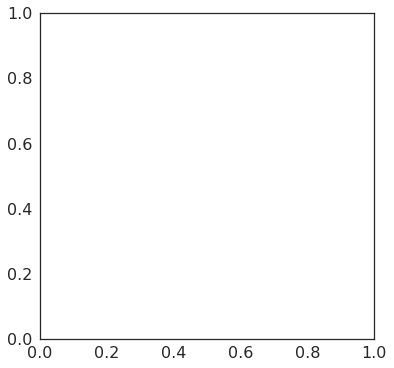

In [5]:
fig, ax_null = plt.subplots()

In [6]:
def clonality_proportion_dcb_plot(ax=None):
    if ax is None:
        ax = plt.gca()
        
    results_clonality = cohort.plot_benefit(on="Clonality", ax=ax_null)
    clonality_significant = results_clonality.p_value <= 0.05
    results_fraction = cohort.plot_benefit(on="T-cell fraction", ax=ax_null)
    fraction_significant = results_fraction.p_value <= 0.05
    
    cols, df_clonality_fraction_init = cohort.as_dataframe(on={"TIL Clonality": "Clonality", 
                                                               "TIL Proportion": "T-cell fraction"},
                                                      return_cols=True)
    df_clonality_fraction_benefit = df_clonality_fraction_init[["patient_id", "benefit"]].set_index("patient_id")
    df_clonality_fraction = df_clonality_fraction_init[cols + ["patient_id"]]
    df_clonality_fraction.set_index("patient_id", inplace=True)
    df_clonality_fraction = pd.DataFrame(df_clonality_fraction.unstack())
    df_clonality_fraction["TIL Measurement"] = df_clonality_fraction.index.get_level_values(0)
    df_clonality_fraction.columns = ["Percent", "TIL Measurement"]
    df_clonality_fraction = df_clonality_fraction.join(df_clonality_fraction_benefit)
    df_clonality_fraction["Response"] = df_clonality_fraction.benefit.apply(
        lambda b: cohort.benefit_plot_name if b else "No " + cohort.benefit_plot_name)

    def add_significance_indicators(plot, indicators=[]):
        from cohorts.plot import vertical_percent
        plot_bottom, plot_top = plot.get_ylim()
        # Give the plot a little room for the significance indicator
        line_height = vertical_percent(plot, 0.1)
        # Add some extra spacing below the indicator
        plot_top = plot_top + line_height
        # Add some extra spacing above the indicator
        plot.set_ylim(top=plot_top + line_height * 2)
        color = "black"
        line_top = plot_top + line_height
        for col_a, col_b, significant in indicators:
            plot.plot([col_a, col_a, col_b, col_b], [plot_top, line_top, line_top, plot_top], lw=1.5, color=color)
            indicator = "*" if significant else "ns"
            plot.text((col_a + col_b) * 0.5, line_top, indicator, ha="center", va="bottom", color=color)
    
    box_ax = sb.boxplot(data=df_clonality_fraction, y="Percent", x="TIL Measurement", hue="Response",
                         ax=ax)
    # http://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend
    strip_ax = sb.stripplot(data=df_clonality_fraction, jitter=0.05, palette={cohort.benefit_plot_name: "0.3", 
                                                                              ("No " + cohort.benefit_plot_name): "0.3"}, split=True, y="Percent", x="TIL Measurement", hue="Response",
                         ax=ax)
    
    add_significance_indicators(ax, [(-0.2, 0.2, clonality_significant), (0.8, 1.2, fraction_significant)])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    l = ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=0.)

In [7]:
def update_styling():
    import matplotlib as mpl
    mpl.rcParams.update({"legend.fontsize": 15})

inner join with tcr_tumor: 29 to 24 rows
inner join with tcr_tumor: 29 to 24 rows
{'dataframe_hash': -2467646966976180658,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=91.0, p-value=0.104634955402 (two-sided)
inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=97.0, p-value=0.0465677613869 (two-sided)
inner join with tcr_tumor: 29 to 24 rows
inner join with tcr_tumor: 29 to 24 rows
inner join with tcr_tumor: 29 to 24 rows
< Median TIL Proportion or
 < Median TIL Clonality  False  True 
Response  

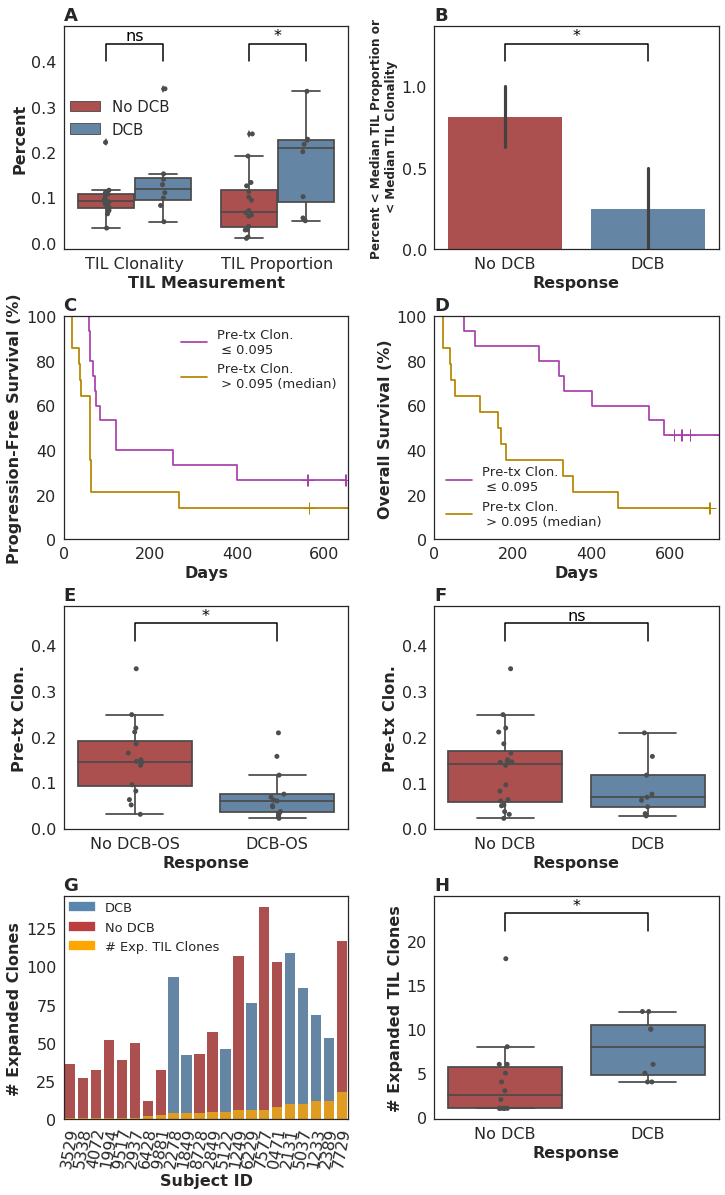

In [8]:
fig, axarr = plt.subplots(4, 2)
fig.set_size_inches(2250 / 225, 2625 / 225)

title_loc = "left"
title_fontsize = 18
title_kwargs = {"loc": title_loc, "fontsize": title_fontsize, "fontweight": "bold"}

cohort = data.init_cohort(join_with="tcr_tumor",
                          exclude_patient_ids=set(),
                          only_patients_with_bams=False)

"""
Removed for now.

df = cohort.as_dataframe(["Clonality", "T-cell fraction"])
results = cohort.plot_correlation(on={"TIL Clonality": "Clonality", "TIL Proportion": "T-cell fraction"}, x_col="TIL Clonality", 
                          plot_type="regplot",
                          plot_kwargs={"ax": axarr[0,0],
                                       "fit_reg": False,
                                       "scatter_kws": {"s": 200,
                                       "c": ["green" if benefit else "red" for benefit in df.is_benefit]}})
results.plot.set_xlim((0, 0.4))
results.plot.set_ylim((0, 0.4))
results.plot.set_title("A", **title_kwargs)
"""

update_styling()
clonality_proportion_dcb_plot(ax=axarr[0,0])
axarr[0,0].set_title("A", **title_kwargs)

df_til = cohort.as_dataframe()
def below_either_median(row):
    either = ((row["Clonality"] < df_til["Clonality"].median()) or 
              (row["T-cell fraction"] < df_til["T-cell fraction"].median()))
    return either
cohort.plot_benefit({"< Median TIL Proportion or\n < Median TIL Clonality": below_either_median},
                                                     ax=axarr[0,1])

labels = [label.get_text() for label in axarr[0,1].get_yticklabels()]
update_styling()
ylabel = axarr[0,1].get_ylabel()
axarr[0,1].set_ylabel(ylabel, fontsize=12)
axarr[0,1].set_title("B", **title_kwargs)
# Hide 1.25 for the sig indiciator
axarr[0,1].set_yticklabels(["0.0", "", "0.5", "", "1.0", ""])

cohort = data.init_cohort(join_with="tcr_peripheral_a",
                          exclude_patient_ids=set(),
                          only_patients_with_bams=False)

cohort.tcr_peripheral_a_clonality_short_plot_name = "Pre-tx Clon.\n"

update_styling()
import matplotlib as mpl
mpl.rcParams.update({"legend.fontsize": 13})
cohort.plot_survival(on={cohort.tcr_peripheral_a_clonality_short_plot_name: "Clonality"}, how="pfs", ax=axarr[1,0])
ax=axarr[1,0].set_title("C", **title_kwargs)
axarr[1,0].set_yticklabels([0, 20, 40, 60, 80, 100])

update_styling()
import matplotlib as mpl
mpl.rcParams.update({"legend.fontsize": 13})
cohort.plot_survival(on={cohort.tcr_peripheral_a_clonality_short_plot_name: "Clonality"}, how="os", ax=axarr[1,1])
ax=axarr[1,1].set_title("D", **title_kwargs)
axarr[1,1].legend(loc='lower left')
axarr[1,1].set_yticklabels([0, 20, 40, 60, 80, 100])

cohort.tcr_peripheral_a_clonality_short_plot_name = "Pre-tx Clon."

cohort.plot_benefit_os(on={cohort.tcr_peripheral_a_clonality_short_plot_name: "Clonality"}, ax=axarr[2,0])
ax=axarr[2,0].set_title("E", **title_kwargs)

cohort.plot_benefit(on={cohort.tcr_peripheral_a_clonality_short_plot_name: "Clonality"}, ax=axarr[2,1])
ax=axarr[2,1].set_title("F", **title_kwargs)

cohort_tcr_a_b = data.init_cohort(join_with="tcr_expansion_a_b", 
                          exclude_patient_ids=set(),
                          only_patients_with_bams=False)

expanded_clones_barplot(cohort_a_b=cohort_tcr_a_b, ax=axarr[3,0])
ax=axarr[3,0].set_title("G", **title_kwargs)

cohort_tcr_a_b.plot_benefit(
        {"# Expanded TIL Clones": "N Expanded Clones that were TILs"}, ax=axarr[3,1])
ax=axarr[3,1].set_title("H", **title_kwargs)

plt.subplots_adjust(bottom=-0.5)
plt.subplots_adjust(left=-0.01)
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3)

hyper_figure_label_printer("figure_tcr")

fig.savefig(path.join(data.REPO_DATA_DIR, 'Fig1.tif'), format='tif', dpi=300, bbox_inches='tight')

In [9]:
from utils.paper import resize_image_plos
resize_image_plos("Fig1.tif", "Fig1.tif", figure_path=data.REPO_DATA_DIR)